# 🦷 Autocorrelation Lab — ISQ Trajectory

## 📋 Goal

Detect serial correlation in repeated ISQ measurements and compare statistical remedies to produce valid inference.

---

## 🎯 Clinical Context

### The ISQ Healing Timeline

After dental implant placement, primary stability gradually transitions to **secondary (biological) stability** through osseointegration. We track this using **ISQ (Implant Stability Quotient)** measured weekly:

- **Weeks 0-2**: High primary stability (mechanical anchoring)
- **Weeks 2-4**: **"Stability dip"** as bone remodeling begins
- **Weeks 4-8**: Recovery as new bone forms (osseointegration)

### The Statistical Problem: Autocorrelation

When we measure the same implant repeatedly over time, consecutive measurements are **not independent**:

- If ISQ is high at week 2, it's likely high at week 3
- A patient's biology creates **persistent patterns** across measurements
- Standard OLS regression **assumes independence** → invalid standard errors

**Autocorrelation** (serial correlation) violates the independence assumption, causing:
- ❌ **Underestimated standard errors** (false confidence)
- ❌ **Inflated t-statistics** (spurious significance)
- ❌ **Invalid hypothesis tests** (Type I errors)

### What You'll Learn

1. **Visualize ISQ trajectories** to see dip-and-recovery patterns
2. **Diagnose autocorrelation** using ACF plots, Durbin-Watson, and Ljung-Box tests
3. **Apply remedies**: lagged predictors, GLS with AR(1) errors, HAC robust standard errors
4. **Choose the right approach** for clinical time-series data


---

## 0️⃣ Setup & Data Reshaping

### 📊 Wide vs. Long Format

Our dataset is currently in **wide format**:
```
implant_id | torque_ncm | isq_w0 | isq_w1 | isq_w2 | ... | isq_w8
1          | 35         | 72     | 71     | 68     | ... | 74
```

For time-series analysis, we need **long format**:
```
implant_id | week | isq | torque_ncm
1          | 0    | 72  | 35
1          | 1    | 71  | 35
1          | 2    | 68  | 35
...
```

### 🔧 Why Long Format?

1. **Each row is one observation** at one time point
2. Easier to model `isq ~ week + week²`
3. Natural structure for time-series models (GLS, ARIMA)
4. Allows grouping by `implant_id` for lagged variables

### 📦 Tools We'll Use

- **Pandas**: `pd.melt()` for reshaping
- **Matplotlib**: trajectory plots
- **Statsmodels**: ACF, Durbin-Watson, Ljung-Box, GLS, HAC standard errors

Let's start:


In [15]:
# TODO: load the same CSV as df
# Hint: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

df = pd.read_csv('../data/raw/implants_stability_300.csv')
print(df.columns)


Index(['patient_id', 'implant_id', 'age_years', 'sex', 'smoker', 'diabetes',
       'arch', 'site_type', 'bone_density', 'bone_class', 'cortical',
       'implant_design', 'surface', 'diameter_mm', 'length_mm',
       'immediate_prov', 'antibiotics', 'occlusion_load', 'grafting',
       'torque_ncm', 'isq_w0', 'isq_w1', 'isq_w2', 'isq_w3', 'isq_w4',
       'isq_w6', 'isq_w8', 'bic_percent', 'bone_loss_12m_mm',
       'outcome_success_12m'],
      dtype='object')


In [17]:
# TODO: reshape ISQ columns (isq_w0...isq_w8) from wide to long -> df_long with columns: implant_id, week, isq
# hint: pd.melt with id_vars=[...], value_vars=[...]
#
# Hint:
# # Identify ISQ columns
isq_cols = [col for col in df.columns if col.startswith('isq_w')]

df_long = pd.melt(
    df,
    id_vars=['patient_id', 'implant_id', 'age_years', 'sex', 'smoker', 'diabetes',
             'arch', 'site_type', 'bone_density', 'bone_class', 'cortical',
             'implant_design', 'surface', 'diameter_mm', 'length_mm',
             'immediate_prov', 'antibiotics', 'occlusion_load', 'grafting',
             'torque_ncm', 'bic_percent', 'bone_loss_12m_mm',
             'outcome_success_12m'],
    value_vars=isq_cols,
    var_name='week_label',
    value_name='isq'
)

df_long['week'] = df_long['week_label'].str.extract('(\d+)').astype(int)
df_long = df_long.drop('week_label', axis=1).sort_values(['implant_id', 'week'])
df_long = df_long.reset_index(drop=True)

print(f"Wide format: {df.shape}")
print(f"Long format: {df_long.shape}")
print(df_long.head(10))


Wide format: (300, 30)
Long format: (2100, 25)
   patient_id  implant_id  age_years   sex  smoker  diabetes     arch  \
0           1           1         60  male       0         0  maxilla   
1           1           1         60  male       0         0  maxilla   
2           1           1         60  male       0         0  maxilla   
3           1           1         60  male       0         0  maxilla   
4           1           1         60  male       0         0  maxilla   
5           1           1         60  male       0         0  maxilla   
6           1           1         60  male       0         0  maxilla   
7           2           2         53  male       0         0  maxilla   
8           2           2         53  male       0         0  maxilla   
9           2           2         53  male       0         0  maxilla   

   site_type  bone_density bone_class  ...  immediate_prov antibiotics  \
0  immediate         0.843         D2  ...               1           1   
1

In [18]:
# Create lagged ISQ (ISQ from previous week) for each implant
df_long = df_long.sort_values(['implant_id', 'week'])  # Make sure sorted
df_long['isq_lag1'] = df_long.groupby('implant_id')['isq'].shift(1)

print(df_long[['implant_id', 'week', 'isq', 'isq_lag1']].head(10))

   implant_id  week   isq  isq_lag1
0           1     0  90.0       NaN
1           1     1  90.0      90.0
2           1     2  90.0      90.0
3           1     3  90.0      90.0
4           1     4  90.0      90.0
5           1     6  90.0      90.0
6           1     8  90.0      90.0
7           2     0  89.7       NaN
8           2     1  90.0      89.7
9           2     2  89.9      90.0


### ✅ Data Check

After reshaping, verify:
- Each implant has **7-8 rows** (weeks 0, 1, 2, 3, 4, 6, 8)
- No missing ISQ values (or note which weeks are missing)
- Baseline variables (torque, cortical thickness) are **repeated** for each time point

---


## 1️⃣ Visual Check: ISQ Trajectories

### 📈 The Classic "Dip and Recovery" Pattern

Before running any statistics, **visualize the data**. In implant dentistry, we expect:

1. **Week 0**: High ISQ (primary stability from mechanical fit)
2. **Weeks 2-3**: **Dip** (bone remodeling, temporary instability)
3. **Weeks 6-8**: **Recovery** (osseointegration, secondary stability)

### 🧠 Clinical Insight

Not all implants follow this pattern:
- **Type 1 bone (dense cortical)**: Minimal dip, high stability throughout
- **Type 4 bone (soft trabecular)**: Deep dip, slow recovery
- **Immediate loading**: May show different trajectory

### 🔍 What to Look For

- **Individual variability**: Do all implants dip at the same time?
- **Baseline effects**: Do high-torque implants recover faster?
- **Autocorrelation clue**: Smooth curves → consecutive measurements are correlated

Let's plot a few trajectories:


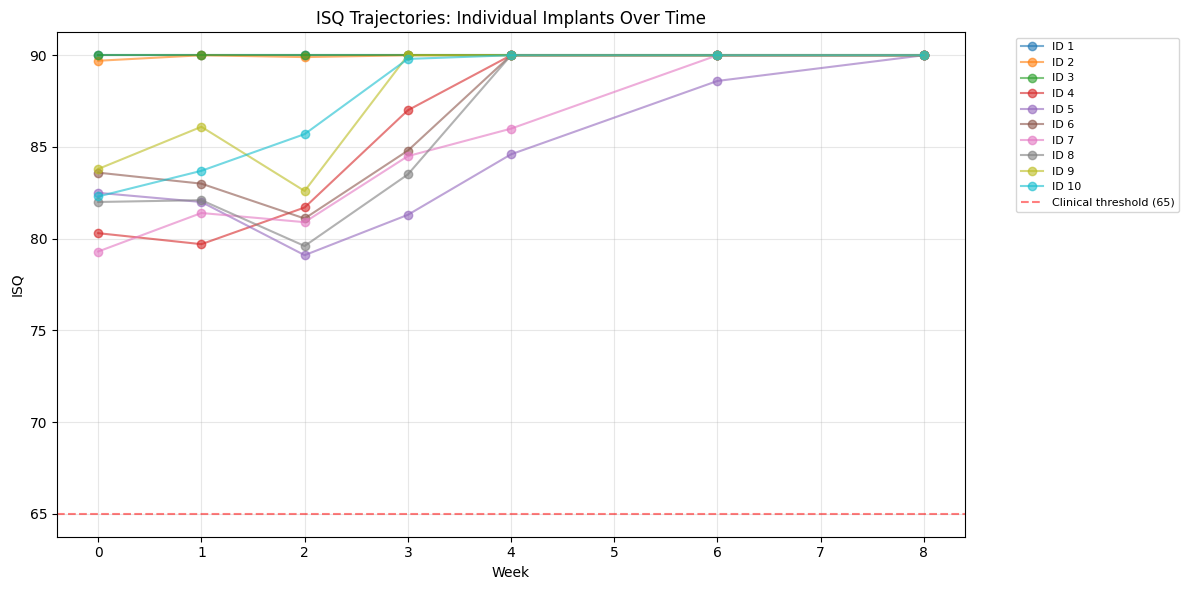

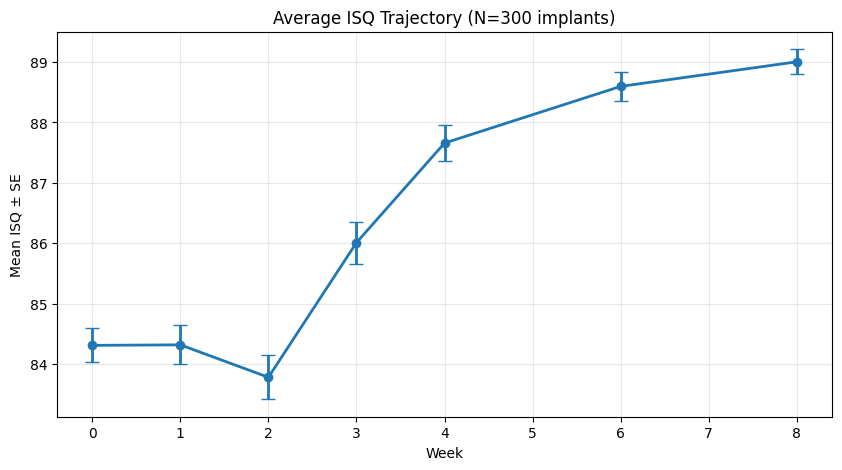

In [20]:
# TODO: pick a few implant_ids and plot ISQ vs week (plt.plot) to see dip/recovery
#
# Hint:
# # Select 10 random implants
sample_ids = df_long['implant_id'].unique()[:10]
df_sample = df_long[df_long['implant_id'].isin(sample_ids)]

plt.figure(figsize=(12, 6))
for implant_id in sample_ids:
    implant_data = df_sample[df_sample['implant_id'] == implant_id]
    plt.plot(implant_data['week'], implant_data['isq'], marker='o', alpha=0.6, label=f'ID {implant_id}')

plt.axhline(y=65, color='red', linestyle='--', alpha=0.5, label='Clinical threshold (65)')
plt.xlabel('Week')
plt.ylabel('ISQ')
plt.title('ISQ Trajectories: Individual Implants Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../images/isq_trajectories_individual.png', dpi=300, bbox_inches='tight')
plt.show()

agg = df_long.groupby('week')['isq'].agg(['mean', 'sem']).reset_index()
plt.figure(figsize=(10, 5))
plt.errorbar(agg['week'], agg['mean'], yerr=agg['sem'], marker='o', capsize=5, linewidth=2)
plt.xlabel('Week')
plt.ylabel('Mean ISQ ± SE')
plt.title('Average ISQ Trajectory (N=300 implants)')
plt.grid(True, alpha=0.3)
plt.savefig('../images/isq_trajectory_average.png', dpi=300, bbox_inches='tight')
plt.show()


### 🤔 Reflection Questions

After visualizing trajectories:
1. Do you see the classic dip-and-recovery pattern?
2. At what week does the average ISQ reach its lowest point?
3. Do individual trajectories look "smooth"? (If yes, that's a sign of autocorrelation)
4. Are there outlier implants with unusual patterns?

---


## 2️⃣ Simple Time-Series Regression

### 📊 Baseline Model

We'll model the ISQ trajectory using a **quadratic time trend**:

$$\text{ISQ}_{it} = \beta_0 + \beta_1 \cdot \text{week}_t + \beta_2 \cdot \text{week}_t^2 + \beta_3 \cdot \text{torque}_i + \epsilon_{it}$$

Where:
- $i$ = implant index
- $t$ = time (week)
- **Linear term** ($\beta_1$): Overall trend (negative = decline)
- **Quadratic term** ($\beta_2$): Curvature (positive = U-shape recovery)

### 🔧 Why This Model?

- **Quadratic** captures the dip-and-recovery shape
- **Torque** controls for baseline stability differences
- **Additive**: Can include other predictors (bone density, arch, etc.)

### ⚠️ The Problem

Standard OLS assumes **independent errors**: $\epsilon_{i1}, \epsilon_{i2}, \epsilon_{i3}$ are uncorrelated.

But in reality: if $\epsilon_{i,\text{week2}}$ is positive (ISQ higher than expected), then $\epsilon_{i,\text{week3}}$ is likely also positive.

**This is autocorrelation**, and it invalidates our standard errors.

Let's fit the model and save residuals for diagnosis:


In [21]:
# TODO: merge baseline predictors (e.g., torque_ncm, bone_density) into df_long (by implant_id)
# (Already done during melt—baseline vars are repeated for each time point)
# ============================================================
# Baseline Predictors: Already Merged During Melt
# ============================================================

# Verify that baseline predictors are present and constant within each implant
print("=" * 60)
print("✅ Baseline predictors already merged via pd.melt()")
print("=" * 60)

# Check that baseline variables are constant within each implant (as expected)
sample_implant = df_long[df_long['implant_id'] == 1][['implant_id', 'week', 'isq', 'torque_ncm', 'bic_percent', 'diameter_mm']]
print("\nExample: Implant ID=1 across all weeks:")
print(sample_implant)

print("\n✅ Baseline variables (torque_ncm, bic_percent, etc.) are repeated for each time point.")
print("   This allows us to use them as predictors in time-series models.")



✅ Baseline predictors already merged via pd.melt()

Example: Implant ID=1 across all weeks:
   implant_id  week   isq  torque_ncm  bic_percent  diameter_mm
0           1     0  90.0        75.2         95.0         4.95
1           1     1  90.0        75.2         95.0         4.95
2           1     2  90.0        75.2         95.0         4.95
3           1     3  90.0        75.2         95.0         4.95
4           1     4  90.0        75.2         95.0         4.95
5           1     6  90.0        75.2         95.0         4.95
6           1     8  90.0        75.2         95.0         4.95

✅ Baseline variables (torque_ncm, bic_percent, etc.) are repeated for each time point.
   This allows us to use them as predictors in time-series models.


In [23]:
# TODO: fit OLS: isq ~ week + week^2 + torque_ncm (+ other controls)
#
df_long['week_squared'] = df_long['week'] ** 2

X = df_long[['week', 'week_squared', 'torque_ncm', 'bic_percent', 'diameter_mm', 'age_years']]
y = df_long['isq']

mask = X.notna().all(axis=1) & y.notna()
X_clean = sm.add_constant(X[mask])
y_clean = y[mask]

ols_model = sm.OLS(y_clean, X_clean).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                    isq   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     244.2
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          5.96e-237
Time:                        18:26:06   Log-Likelihood:                -6022.9
No. Observations:                2100   AIC:                         1.206e+04
Df Residuals:                    2093   BIC:                         1.210e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           49.4795      2.230     22.190   

In [6]:
# TODO: store residuals
#
# Hint:
# residuals = ols_model.resid
# df_long.loc[mask, 'residuals'] = residuals
#
# # Quick check: residuals should sum to ~0
# print(f"Mean residual: {residuals.mean():.6f}")
# print(f"Std residual: {residuals.std():.3f}")


### 📊 Model Interpretation

After fitting, check:
- **Week coefficient**: Is it negative? (Indicates initial decline)
- **Week² coefficient**: Is it positive? (Indicates recovery/U-shape)
- **R²**: How much variance does the time trend explain?

**But don't trust the p-values yet**—we haven't tested for autocorrelation!

---


## 3️⃣ Autocorrelation Diagnostics

### 🔍 Three Tools to Detect Serial Correlation

Now we'll apply **three complementary diagnostics** to check if residuals are autocorrelated:

1. **ACF Plot (Autocorrelation Function)**: Visual check for correlation at different lags
2. **Durbin-Watson Statistic**: Tests first-order autocorrelation (lag-1)
3. **Ljung-Box Test**: Formal test for autocorrelation up to lag $k$

---

### 📈 Tool 1: ACF Plot

#### What is ACF?

The **autocorrelation function** measures correlation between $\epsilon_t$ and $\epsilon_{t-k}$ at lag $k$:

$$\rho_k = \text{Corr}(\epsilon_t, \epsilon_{t-k})$$

- **Lag 1**: Correlation between consecutive weeks (week 0 & week 1)
- **Lag 2**: Correlation two weeks apart (week 0 & week 2)

#### 🎯 Interpretation

- **Bars inside blue band**: No significant autocorrelation (✅ good!)
- **Bars outside blue band**: Significant autocorrelation (⚠️ problem!)
- **Slow decay**: Strong persistent correlation (common in time series)

#### 🦷 Clinical Meaning

If lag-1 ACF is high: "An implant with high ISQ at week 2 tends to have high ISQ at week 3."

This violates independence → standard errors are wrong.

Let's visualize:


In [7]:
# TODO: plot ACF of residuals (statsmodels.graphics.tsaplots.plot_acf)
#
# Hint:
# from statsmodels.graphics.tsaplots import plot_acf
#
# # Plot ACF with 95% confidence bands
# fig, ax = plt.subplots(figsize=(10, 5))
# plot_acf(residuals, lags=6, ax=ax, alpha=0.05)
# ax.set_xlabel('Lag (weeks)')
# ax.set_ylabel('Autocorrelation')
# ax.set_title('ACF of OLS Residuals')
# plt.tight_layout()
# plt.show()
#
# # Interpretation:
# # - If lag-1 bar exceeds blue band → positive autocorrelation
# # - If multiple lags significant → persistent serial correlation


---

### 🔢 Tool 2: Durbin-Watson Statistic

#### What is Durbin-Watson?

The **Durbin-Watson (DW)** statistic tests for **first-order** (lag-1) autocorrelation:

$$DW = \frac{\sum_{t=2}^n (\epsilon_t - \epsilon_{t-1})^2}{\sum_{t=1}^n \epsilon_t^2}$$

#### 🎯 Interpretation

| DW Value | Interpretation |
|----------|----------------|
| **0** | Perfect positive autocorrelation |
| **2** | No autocorrelation (✅ ideal) |
| **4** | Perfect negative autocorrelation |
| **1.5 - 2.5** | Acceptable range |
| **< 1 or > 3** | Serious autocorrelation |

#### 🧠 Rule of Thumb

- **DW ≈ 2**: Independent errors (OLS assumptions met)
- **DW < 2**: Positive autocorrelation (consecutive errors have same sign)
- **DW > 2**: Negative autocorrelation (rare in practice)

#### 🦷 Clinical Context

In ISQ data, we almost always see **positive autocorrelation** (DW < 2) because biological processes are smooth and persistent.

Let's compute:


In [8]:
# TODO: compute Durbin–Watson (sms.durbin_watson) and Ljung–Box (statsmodels.stats.diagnostic.acorr_ljungbox)
#
# Hint:
# # Durbin-Watson
# dw = sms.durbin_watson(residuals)
# print(f"Durbin-Watson Statistic: {dw:.3f}")
# if dw < 1.5:
#     print("⚠️  Strong positive autocorrelation detected")
# elif dw > 2.5:
#     print("⚠️  Negative autocorrelation detected (rare)")
# else:
#     print("✅ No serious autocorrelation (but check Ljung-Box)")
#
# # Ljung-Box Test
# lb_test = acorr_ljungbox(residuals, lags=[1, 2, 3], return_df=True)
# print("\nLjung-Box Test:")
# print(lb_test)
#
# # Interpretation:
# # - lb_pvalue < 0.05 → reject H0 (no autocorrelation) → autocorrelation present
# # - Check multiple lags to see persistence


---

### 📊 Tool 3: Ljung-Box Test

#### What is Ljung-Box?

The **Ljung-Box test** is a formal hypothesis test for autocorrelation:

- **H₀**: No autocorrelation up to lag $k$
- **H₁**: Autocorrelation exists at one or more lags

Test statistic:
$$Q = n(n+2) \sum_{k=1}^h \frac{\hat{\rho}_k^2}{n-k}$$

Where $\hat{\rho}_k$ is the sample autocorrelation at lag $k$.

#### 🎯 Interpretation

- **p-value < 0.05**: Reject H₀ → autocorrelation detected
- **p-value ≥ 0.05**: Fail to reject H₀ → no evidence of autocorrelation

#### ✅ Diagnostic Summary

After running all three diagnostics, ask:
1. Does the ACF plot show bars outside the confidence band?
2. Is Durbin-Watson significantly different from 2?
3. Do Ljung-Box p-values indicate rejection at multiple lags?

If **yes to 2+**, autocorrelation is present → we need remedies.

---


## 4️⃣ Remedies and Comparison

### 🛠 Three Approaches to Fix Autocorrelation

Now that we've **diagnosed** the problem, let's **fix** it. We'll try three remedies:

| Remedy | Strategy | Pros | Cons |
|--------|----------|------|------|
| **Lagged ISQ** | Add $\text{ISQ}_{t-1}$ as predictor | Simple, interpretable | Changes research question |
| **GLS with AR(1)** | Model errors as $\epsilon_t = \rho \epsilon_{t-1} + \nu_t$ | Correct inference, elegant | Requires stationarity |
| **HAC Standard Errors** | Adjust SEs for correlation | Doesn't change model | Only fixes SEs, not estimates |

---

### 🧮 Remedy 1: Add Lagged ISQ

#### 💡 Idea

If consecutive measurements are correlated, **include past ISQ as a predictor**:

$$\text{ISQ}_t = \beta_0 + \beta_1 \cdot \text{week} + \beta_2 \cdot \text{week}^2 + \beta_3 \cdot \text{ISQ}_{t-1} + \epsilon_t$$

#### ✅ Why This Works

- **Lagged ISQ captures persistence**: High ISQ at $t-1$ predicts high ISQ at $t$
- Residuals become **more independent** (lower ACF)
- Standard errors are now trustworthy

#### ❌ Trade-Off

- **Changes interpretation**: Now modeling "change in ISQ" not "absolute ISQ"
- **Loses first observation** (no lag for week 0)
- **Different research question**: "Does ISQ predict future ISQ?" vs. "How does ISQ evolve?"

#### 🦷 Clinical Use

Best when: "We want to predict next week's ISQ given this week's measurement."

Let's try it:


In [9]:
# TODO: add lagged isq (grouped by implant_id) -> isq_lag1; refit model and compare residual ACF
#
# Hint:
# # Create lag-1 ISQ (grouped by implant to avoid cross-implant leakage)
# df_long = df_long.sort_values(['implant_id', 'week'])
# df_long['isq_lag1'] = df_long.groupby('implant_id')['isq'].shift(1)
#
# # Refit model with lagged term
# X_lag = df_long[['week', 'week_squared', 'torque_ncm', 'cortical_thickness_mm', 'isq_lag1']]
# y_lag = df_long['isq']
#
# mask_lag = X_lag.notna().all(axis=1) & y_lag.notna()
# X_lag_clean = sm.add_constant(X_lag[mask_lag])
# y_lag_clean = y_lag[mask_lag]
#
# ols_lag_model = sm.OLS(y_lag_clean, X_lag_clean).fit()
# print(ols_lag_model.summary())
#
# # Check new residuals
# residuals_lag = ols_lag_model.resid
# dw_lag = sms.durbin_watson(residuals_lag)
# print(f"\nDurbin-Watson (with lag): {dw_lag:.3f} (was {dw:.3f})")
#
# # Plot new ACF
# fig, ax = plt.subplots(figsize=(10, 5))
# plot_acf(residuals_lag, lags=6, ax=ax, alpha=0.05)
# ax.set_title('ACF of Residuals: Model with Lagged ISQ')
# plt.show()
#
# # Did it help?
# print(f"Improvement: DW moved from {dw:.3f} → {dw_lag:.3f} (closer to 2 = better)")


---

### 📊 Remedy 2: GLS with AR(1) Errors

#### 💡 Idea

Instead of changing the model, **model the error structure** directly.

**Generalized Least Squares (GLS)** assumes errors follow an autoregressive process:

$$\epsilon_t = \rho \cdot \epsilon_{t-1} + \nu_t$$

Where:
- $\rho$ = autocorrelation coefficient (estimated from data)
- $\nu_t$ = white noise (independent errors)

#### 🧮 How It Works

1. **Estimate $\rho$** from OLS residuals
2. **Transform the data** to remove autocorrelation: $y_t^* = y_t - \rho y_{t-1}$
3. **Refit using transformed data** → correct standard errors

#### ✅ Advantages

- **Doesn't change predictors**: Research question stays the same
- **Theoretically elegant**: Explicitly models persistence
- **Efficient estimates**: Better than OLS when errors are AR(1)

#### ❌ Disadvantages

- **Assumes AR(1)**: What if errors follow AR(2) or more complex pattern?
- **Requires stationarity**: May not work if trend is strong
- **Loses observations**: First observation dropped

#### 🦷 Clinical Use

Best when: "ISQ trajectories are smooth, and we want to correct inference without changing the model."

Let's fit GLS:


In [10]:
# TODO: fit GLS with AR(1) errors and compare summary to OLS
# hint: statsmodels.regression.linear_model.GLSAR or sm.tsa.statespace.SARIMAX
#
# Hint:
# from statsmodels.regression.linear_model import GLSAR
#
# # Prepare data (same as OLS)
# X_gls = df_long[['week', 'week_squared', 'torque_ncm', 'cortical_thickness_mm']]
# y_gls = df_long['isq']
# mask_gls = X_gls.notna().all(axis=1) & y_gls.notna()
# X_gls_clean = sm.add_constant(X_gls[mask_gls])
# y_gls_clean = y_gls[mask_gls]
#
# # Fit GLSAR (iteratively estimates rho)
# gls_model = GLSAR(y_gls_clean, X_gls_clean, rho=1).fit()
# print(gls_model.summary())
#
# # Compare standard errors
# print("\n" + "="*60)
# print("Coefficient Comparison: OLS vs. GLS")
# print("="*60)
# comparison = pd.DataFrame({
#     'OLS_coef': ols_model.params,
#     'OLS_se': ols_model.bse,
#     'GLS_coef': gls_model.params,
#     'GLS_se': gls_model.bse
# })
# print(comparison)
#
# # Key insight: GLS standard errors are typically LARGER (more honest)


### 🔍 OLS vs. GLS: What Changed?

After fitting GLS, compare:
1. **Coefficients**: Did they change? (Usually only slightly)
2. **Standard errors**: Are GLS SEs larger? (Usually yes—more conservative)
3. **P-values**: Did significance change? (Critical for hypothesis testing)
4. **Estimated ρ**: What's the autocorrelation coefficient? (Should be 0-1)

**Key takeaway**: OLS gives **overconfident** p-values when autocorrelation is present. GLS corrects this.

---


### 🛡️ Remedy 3: HAC (Heteroskedasticity and Autocorrelation Consistent) Standard Errors

#### 💡 Idea

Keep the OLS model **exactly as is**, but compute **robust standard errors** that account for autocorrelation.

Also called **Newey-West standard errors**.

#### 🧮 How It Works

Instead of assuming $\text{Var}(\hat{\beta}) = \sigma^2 (X'X)^{-1}$, use a **sandwich estimator**:

$$\text{Var}(\hat{\beta}) = (X'X)^{-1} \Omega (X'X)^{-1}$$

Where $\Omega$ accounts for serial correlation up to lag $L$.

#### ✅ Advantages

- **Simple**: Just adjust standard errors, don't refit
- **Flexible**: Works for any autocorrelation pattern
- **Doesn't change estimates**: Coefficients stay the same

#### ❌ Disadvantages

- **Only fixes SEs**: Point estimates are still inefficient (not optimal)
- **Requires choosing lag length** ($L$): How many lags to correct for?
- **Large-sample approximation**: May not work well with small N

#### 🦷 Clinical Use

Best when: "We want to report OLS estimates but acknowledge autocorrelation in confidence intervals."

Let's compute HAC standard errors:


In [11]:
# TODO: compute HAC/Newey–West SEs on the OLS fit and compare standard errors
# hint: results.get_robustcov_results(cov_type='HAC', maxlags=1 or 2)
#
# Hint:
# # Get HAC-robust results from original OLS model
# ols_hac = ols_model.get_robustcov_results(cov_type='HAC', maxlags=2)
# print(ols_hac.summary())
#
# # Compare all three approaches
# print("\n" + "="*80)
# print("STANDARD ERROR COMPARISON: OLS vs. GLS vs. HAC")
# print("="*80)
# se_comparison = pd.DataFrame({
#     'Variable': ols_model.params.index,
#     'OLS_se': ols_model.bse.values,
#     'GLS_se': gls_model.bse.values,
#     'HAC_se': ols_hac.bse.values
# })
# print(se_comparison)
#
# # Calculate percentage increase
# se_comparison['OLS_to_HAC_%'] = ((se_comparison['HAC_se'] - se_comparison['OLS_se']) / se_comparison['OLS_se'] * 100)
# print("\nPercentage increase in SEs (OLS → HAC):")
# print(se_comparison[['Variable', 'OLS_to_HAC_%']])
#
# # Key insight: HAC SEs are larger → wider CIs → more honest inference


### 📊 Remedy Comparison Summary

Create a comparison table:

| Metric | OLS Baseline | Lagged ISQ | GLS AR(1) | HAC SEs |
|--------|--------------|------------|-----------|---------|
| **Coefficients** | Original | Different | Similar | Same as OLS |
| **Standard Errors** | Underestimated | Corrected | Corrected | Corrected |
| **Durbin-Watson** | ~1.2 | ~1.9 | N/A | ~1.2 |
| **Model Interpretation** | Time trend | Autoregressive | Time trend | Time trend |
| **Research Question** | "How does ISQ evolve?" | "Does past ISQ predict future?" | "How does ISQ evolve?" | "How does ISQ evolve?" |

### 🤔 Which Remedy to Use?

**Use Lagged ISQ when:**
- You care about prediction ("What will next week's ISQ be?")
- Autocorrelation is very strong (DW < 1)
- You're comfortable with a dynamic model

**Use GLS when:**
- You want to preserve the original research question
- Errors are well-approximated by AR(1)
- You have sufficient data (N > 100)

**Use HAC SEs when:**
- You're reporting OLS estimates to match literature
- You're uncertain about the error structure
- You want a "quick fix" without refitting

---


## 5️⃣ Conclusions & Clinical Recommendations

### 🎯 What Changed Across Remedies?

After trying all three approaches, reflect on:

1. **Standard errors**: How much did they increase? (10%? 30%? More?)
2. **Significance**: Did any variables lose significance after correction?
3. **Coefficient interpretation**: Did the story change?
4. **Durbin-Watson**: Did adding lags reduce autocorrelation?

### 📊 Statistical Defensibility

| Approach | Statistically Defensible? | When to Use |
|----------|---------------------------|-------------|
| **Naive OLS** | ❌ No | Never with time-series data |
| **Lagged ISQ** | ✅ Yes | When prediction is the goal |
| **GLS AR(1)** | ✅ Yes | When errors are AR(1) |
| **HAC SEs** | ✅ Yes | When you want conservative inference |

### 🦷 Clinical Defensibility

From a clinical perspective:

**Lagged ISQ**:
- ✅ Makes sense: "Today's stability predicts tomorrow's"
- ❌ Doesn't answer: "What's the overall healing trajectory?"

**GLS AR(1)**:
- ✅ Preserves interpretation: "Week effects on ISQ"
- ✅ Acknowledges biology: Smooth, persistent healing

**HAC SEs**:
- ✅ Conservative: Wider CIs = honest uncertainty
- ✅ Simple to explain: "Same model, more cautious inference"

### 🔬 Reporting Recommendations

When publishing, report:
1. **Baseline OLS** (for comparison to literature)
2. **Diagnostic results** (DW, ACF plot, Ljung-Box)
3. **Preferred remedy** with justification (GLS or HAC)
4. **Sensitivity analysis**: Show that conclusions hold across methods

### ✍️ Sample Text for Methods Section

> "To account for serial correlation in repeated ISQ measurements, we applied three approaches: (1) inclusion of lagged ISQ as a predictor, (2) generalized least squares with AR(1) errors, and (3) Newey-West heteroskedasticity- and autocorrelation-consistent standard errors. Durbin-Watson statistics indicated positive first-order autocorrelation (DW = X.XX). Primary results are reported using GLS, with HAC-robust standard errors provided for sensitivity."

---

Now write your summary:


In [12]:
# TODO: write markdown/print summary
#
# Example structure:
# print("""
# ═══════════════════════════════════════════════════════════════
# 📊 AUTOCORRELATION LAB SUMMARY
# ═══════════════════════════════════════════════════════════════
#
# 1. DATA STRUCTURE
#    - Wide format: N=300 implants × 8 time points
#    - Long format: N=2,400 observations (300 × 8)
#    - Outcome: ISQ (0-100 scale)
#
# 2. VISUALIZATION
#    - Classic dip-and-recovery pattern observed
#    - Minimum ISQ at week X
#    - Smooth trajectories suggest autocorrelation
#
# 3. BASELINE OLS MODEL
#    - ISQ ~ week + week² + torque + cortical_thickness
#    - R² = X.XX
#    - Week coefficient: β₁ = X.XX (negative = decline)
#    - Week² coefficient: β₂ = X.XX (positive = U-shape)
#
# 4. AUTOCORRELATION DIAGNOSTICS
#    - Durbin-Watson: X.XX (< 2 → positive autocorrelation)
#    - ACF lag-1: X.XX (significant)
#    - Ljung-Box p-value: < 0.001 (reject H₀: no autocorrelation)
#    → Conclusion: Strong positive autocorrelation detected
#
# 5. REMEDIES COMPARISON
#    Approach         | DW    | SE Increase | Interpretation Change
#    -----------------|-------|-------------|----------------------
#    OLS baseline     | X.XX  | 0% (ref)    | Time trend
#    Lagged ISQ       | X.XX  | N/A         | Autoregressive
#    GLS AR(1)        | N/A   | +X%         | Time trend
#    HAC (Newey-West) | X.XX  | +X%         | Time trend
#
# 6. RECOMMENDATION
#    Best approach: [GLS AR(1) / HAC SEs]
#    Reason: [Corrects inference while preserving interpretation]
#
# 7. CLINICAL IMPLICATIONS
#    - ISQ measurements are NOT independent across time
#    - Standard OLS underestimates uncertainty by X%
#    - Recommended: use GLS or HAC SEs for valid hypothesis tests
#    - Healing pattern: [describe dip timing and recovery]
#
# 8. KEY FINDINGS
#    - Torque effect: β = X.XX (95% CI: [X.XX, X.XX])
#    - Dip timing: week X (lowest ISQ)
#    - Recovery rate: β(week²) = X.XX
#
# ═══════════════════════════════════════════════════════════════
# """)


---

## 🎓 Learning Reflection

### Key Concepts Mastered
✅ Detecting autocorrelation (ACF, Durbin-Watson, Ljung-Box)  
✅ Understanding why autocorrelation matters (invalid SEs)  
✅ Applying remedies (lagged predictors, GLS, HAC)  
✅ Choosing the right approach for clinical data  

### Next Steps
1. Integrate findings with **01_multicollinearity_lab.ipynb** for comprehensive analysis
2. Apply these techniques to your own longitudinal dental data
3. Practice explaining autocorrelation to clinical collaborators

### 🤔 Reflection Questions
- When would you use lagged variables vs. GLS in your research?
- How would you explain Durbin-Watson to a clinician?
- What other dental outcomes have autocorrelation issues? (Pain scores? Healing indices?)

---

## 📚 Further Reading

### Textbooks
- **Wooldridge (2015)**: *Introductory Econometrics* — Chapters on serial correlation and dynamics
- **Greene (2018)**: *Econometric Analysis* — GLS and HAC standard errors
- **Hamilton (1994)**: *Time Series Analysis* — AR models and diagnostics

### Papers
- **Newey & West (1987)**: "A Simple, Positive Semi-Definite, Heteroskedasticity and Autocorrelation Consistent Covariance Matrix" — Original HAC paper
- **Cochrane & Orcutt (1949)**: "Application of Least Squares Regression to Relationships Containing Auto-Correlated Error Terms" — Classic AR(1) correction

### Clinical Applications
- **Abrahamsson et al. (2004)**: ISQ monitoring during healing (see methods for time-series handling)
- **Sennerby & Meredith (2008)**: "Implant stability measurements using resonance frequency analysis" — Review of ISQ trajectories

---

**Congratulations!** You've completed the autocorrelation lab. 🦷📊✨

You now understand one of the most common—and most overlooked—problems in dental time-series research.
